# Task 5: CompGCN with Custom Node Features

**Objective:** Implement a CompGCN (Composition-based Multi-Relational GCN) model for link prediction
that leverages the **custom node attributes** (Gender, Generation, PageRank, Degrees, Community ID) derived in Tasks 1 & 2.

---

## Theoretical Foundation

### Why CompGCN?

Standard KGE models (TransE, DistMult, ComplEx, RotatE) learn entity embeddings **from scratch**
using only the graph structure (triples). They ignore rich node-level features that we carefully
computed in Tasks 1 and 2.

**CompGCN** (Vashishth et al., 2020) is a GNN-based model that:
1. Uses **composition functions** to jointly embed entities and relations
2. Performs **relation-aware message passing** (forward + backward + self-loop)
3. Can accept **custom initial features** instead of random embeddings

### Architecture Overview

```
Node Features (~58-dim)  →  Linear Projection (64-dim)  →  CompGCN Layers  →  RotatE Decoder
  [Gender, Gen, PR,          [Learnable W·x + b]           [Message Passing]    [Score Triples]
   Deg, Community(1-hot)]                                    × 2 layers
```

### The "Dimension Mismatch" Fix

**Problem:** Raw node features have ~58 dimensions (8 base + ~50 community one-hot),
but GNN layers need a fixed hidden dimension (e.g., 64) for effective message passing.

**Solution:** Insert a **learnable projection layer** between the raw features and the GNN:
- `Linear(input_dim, 64)` projects features to GNN's working dimension
- `ReLU` activation adds non-linearity
- Projection weights are **jointly trained** with CompGCN layers

### Data Leakage Prevention for Community Features

Community IDs must be computed **exclusively from the training graph** (train.txt).
If we used the test graph's edges, communities would encode test-time connectivity
patterns, leaking future information into the model.

### Key Hypothesis

> - **PageRank/Degree** capture structural importance patterns

> *CompGCN with custom features (especially Generation, Gender, and Community) should converge*>   are more likely to share relations (siblings, parent-child within the same clan)

> *faster and achieve higher Hits@10 than standard RotatE with random initialization, because:*> - **Community ID** encodes family cluster membership — entities in the same community

> - **Gender** directly constrains gender-specific relations (fatherOf vs motherOf)> - **Generation** constrains generational relationships (parent-child = 1 gen apart)

## 1. Setup

**For Google Colab:**
1. Select a **GPU** runtime (Runtime → Change runtime type → GPU)
2. Run Cell 2 (Colab Setup) to mount Drive and install PyKEEN
3. Run Cell 3 (Imports) to verify GPU and import modules

**For Local:**
1. Skip Cell 2
2. Run Cell 3 directly

In [ ]:
# ==== COLAB SETUP (Skip if running locally) ====
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Precog_task_graphs

# Install PyKEEN (required for CompGCN)
!pip install pykeen -q

# Verify
!ls src/

In [1]:
# ==== IMPORTS ====
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# GPU check
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Using device: {device}")

# Add src to path
src_path = os.path.join(os.getcwd(), 'src') if os.path.exists('src') else os.path.join(os.getcwd(), '..', 'src')
src_path = os.path.abspath(src_path)
if src_path not in sys.path:
    sys.path.insert(0, src_path)
print(f"Source path: {src_path}")

# PyKEEN imports
import pykeen
from pykeen.triples import TriplesFactory
from pykeen.models import ERModel
from pykeen.nn.representation import Representation, CombinedCompGCNRepresentations
from pykeen.pipeline import pipeline
print(f"PyKEEN version: {pykeen.get_version()}")

# Custom modules (from Tasks 1 & 2)
from data_loader import load_graph
from exploration import calculate_node_features, infer_gender
from communities import louvain_communities

print("\nAll imports successful!")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce GTX 1650 Ti
Using device: cuda
Source path: d:\college\Precog\Precog_task_graphs\src
PyKEEN version: 1.11.1

All imports successful!


## 2. Data Loading

We use **PyKEEN's TriplesFactory** to handle entity/relation ID mapping.

**Splitting Strategy: Transductive (Type 2)**
- Random 80/20 split of training triples
- Vocabulary built from the **union** of train + validation
- Ensures all entities in test/validation have embeddings (and features)

**Inverse Triples:** CompGCN **requires** inverse triples for bidirectional message passing.
PyKEEN's `create_inverse_triples=True` automatically creates `relation_inverse` for each relation.

In [2]:
# ==== LOAD DATA ====

def load_triples_array(path):
    """Load triples from file into numpy array for PyKEEN."""
    triples = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 3:
                parts = line.strip().split()
            if len(parts) == 3:
                triples.append(parts)
    return np.array(triples)

# Auto-detect paths (Colab vs local)
if os.path.exists('data/raw/train.txt'):
    train_path = 'data/raw/train.txt'
    test_path = 'data/raw/test.txt'
else:
    train_path = '../data/raw/train.txt'
    test_path = '../data/raw/test.txt'

train_triples = load_triples_array(train_path)
test_triples = load_triples_array(test_path)
print(f"Raw training triples: {len(train_triples)}")
print(f"Raw test triples: {len(test_triples)}")

# ---- Create PyKEEN TriplesFactory ----
# Full factory (shared vocabulary = Transductive)
full_factory = TriplesFactory.from_labeled_triples(
    triples=train_triples,
    create_inverse_triples=True,  # REQUIRED for CompGCN
)

print(f"\nFull TriplesFactory:")
print(f"  Entities: {full_factory.num_entities}")
print(f"  Relations: {full_factory.num_relations} (with inverses)")
print(f"  Real relations: {full_factory.real_num_relations}")
print(f"  Triples: {full_factory.num_triples} (with inverses)")

# ---- Transductive Split (Type 2) ----
training_factory, validation_factory = full_factory.split([0.8, 0.2], random_state=42)

print(f"\nTransductive Split:")
print(f"  Train: {training_factory.num_triples} triples")
print(f"  Valid: {validation_factory.num_triples} triples")

# ---- Test Factory (shared vocab) ----
testing_factory = TriplesFactory.from_labeled_triples(
    triples=test_triples,
    entity_to_id=full_factory.entity_to_id,
    relation_to_id=full_factory.relation_to_id,
    create_inverse_triples=True,
)
print(f"  Test: {testing_factory.num_triples} triples")

# ---- Sanity Check: All test entities in vocab? ----
test_ents = set()
for h, _, t in test_triples:
    test_ents.add(h)
    test_ents.add(t)
train_ents = set(full_factory.entity_to_id.keys())
missing = test_ents - train_ents
print(f"\nSanity Check:")
print(f"  Test entities in vocab: {len(test_ents - missing)}/{len(test_ents)}")
print(f"  Missing entities: {len(missing)}")
if missing:
    print(f"  WARNING: {missing} not in training vocabulary!")

Raw training triples: 13821
Raw test triples: 590

Full TriplesFactory:
  Entities: 1316
  Relations: 56 (with inverses)
  Real relations: 28
  Triples: 13821 (with inverses)

Transductive Split:
  Train: 11056 triples
  Valid: 2765 triples
  Test: 590 triples

Sanity Check:
  Test entities in vocab: 751/751
  Missing entities: 0


## 3. Feature Engineering & Alignment

### Node Attributes (from Tasks 1 & 2)

| Feature | Type | Encoding | Dims | Relevance |
|---------|------|----------|------|-----------|
| **Gender** | Categorical | One-Hot (M/F/O) | 3 | Determines gender-specific relations |
| **Generation** | Ordinal | Min-Max normalized | 1 | Constrains generational relations |
| **PageRank** | Continuous | Min-Max normalized | 1 | Node importance/centrality |
| **In-Degree** | Count | Min-Max normalized | 1 | Incoming connections |
| **Out-Degree** | Count | Min-Max normalized | 1 | Outgoing connections |
| **Total Degree** | Count | Min-Max normalized | 1 | Overall connectivity |
| **Community ID** | Categorical | One-Hot | ~50 | Family cluster membership (Task 2) |

### Data Leakage Guard: Community IDs

Community detection is run on `G_directed` (built from `train.txt` only).
This ensures no test-time edge information leaks into the community structure.
Test entities that happen to appear in train.txt will get their training-derived

community assignment; any entity missing from the training graph gets a zero vector.$$X \in \mathbb{R}^{|E| \times (8 + C)}, \quad X[i] = \text{features of entity } e_i, \quad C = \text{num communities}$$



### AlignmentRow `i` of the feature tensor must correspond to entity with ID `i` in the TriplesFactory.

**Critical:** Features must be aligned to PyKEEN's `entity_to_id` mapping.

In [3]:
# ==== COMPUTE NODE ATTRIBUTES ====

# Load NetworkX graph and compute attributes (reusing Task 1 & 2 pipelines)
# IMPORTANT: G_directed is built from train.txt ONLY → no test data leakage
G_directed, G_undirected = load_graph(train_path)
G_directed = calculate_node_features(G_directed, verbose=True)
G_directed, gender_summary = infer_gender(G_directed, verbose=True)

# ---- Community Detection (Louvain) on TRAINING graph only ----
# This is the critical leakage prevention step: communities are derived
# exclusively from training edges. Test edges play no role.
print("\n" + "="*60)
print("COMMUNITY DETECTION (Louvain) — Training Graph Only")
print("="*60)
print(f"  Graph source: {train_path} (train.txt ONLY)")
print(f"  Nodes: {G_directed.number_of_nodes()}, Edges: {G_directed.number_of_edges()}")

community_partition, community_list = louvain_communities(G_directed, resolution=1.0, verbose=True)
num_communities = len(community_list)

print(f"\n  Leakage check: Community IDs derived from {G_directed.number_of_edges()} training edges")
print(f"  Number of communities (C): {num_communities}")
print(f"  Feature dims: 8 (base) + {num_communities} (community one-hot) = {8 + num_communities}")

Loading graph from: ../data/raw/train.txt
--------------------------------------------------

GRAPH CONSTRUCTION SANITY CHECK

DATA STATISTICS:
   - Total triples processed: 13,821
   - Unique relationship types: 28

DIRECTED GRAPH (G_directed):
   - Nodes: 1,316
   - Edges: 13,821
   - Graph type: DiGraph

UNDIRECTED GRAPH (G_undirected):
   - Nodes: 1,316
   - Edges: 7,480
   - Graph type: Graph

CALCULATING NODE FEATURES

Computing degree metrics...
   - In-Degree:    min=0, max=23, mean=10.50
   - Out-Degree:   min=1, max=22, mean=10.50

Computing centrality metrics...
   - PageRank: max=0.001857, mean=0.000760
   - Betweenness: max=0.0001, mean=0.0000 (analysis only)

   Top 5 nodes by PageRank (Important Ancestors):
      - gabriel241: 0.001857
      - lea1165: 0.001841
      - raphael29: 0.001809
      - christian712: 0.001682
      - tobias713: 0.001682

   Top 5 nodes by Betweenness (Family Bridges):
      - lea1165: 0.0001
      - valentin638: 0.0001
      - gabriel241: 0.000

In [4]:
# ==== BUILD ALIGNED FEATURE TENSOR ====

entity_to_id = full_factory.entity_to_id
num_entities = full_factory.num_entities
BASE_DIM = 8  # Gender(3) + Generation(1) + PageRank(1) + InDeg(1) + OutDeg(1) + TotalDeg(1)
INPUT_DIM = BASE_DIM + num_communities  # + Community one-hot

print(f"Feature dimensions: {BASE_DIM} (base) + {num_communities} (community one-hot) = {INPUT_DIM}")

# ---- Step 1: Collect raw values for normalization stats ----
raw_values = {'generation': [], 'pagerank': [], 'in_degree': [], 'out_degree': [], 'total_degree': []}

for entity_name in entity_to_id:
    if entity_name in G_directed.nodes:
        nd = G_directed.nodes[entity_name]
        raw_values['generation'].append(nd.get('generation', 0))
        raw_values['pagerank'].append(nd.get('pagerank', 0))
        raw_values['in_degree'].append(nd.get('in_degree', 0))
        raw_values['out_degree'].append(nd.get('out_degree', 0))
        raw_values['total_degree'].append(nd.get('in_degree', 0) + nd.get('out_degree', 0))

# Min-Max normalization stats
norm_stats = {}
for key, vals in raw_values.items():
    norm_stats[key] = (min(vals), max(vals))
    print(f"  {key}: min={min(vals):.4f}, max={max(vals):.4f}")

def min_max_normalize(val, vmin, vmax):
    return (val - vmin) / (vmax - vmin + 1e-8)

# ---- Step 2: Build feature tensor aligned to entity_to_id ----
X = torch.zeros(num_entities, INPUT_DIM, dtype=torch.float32)
matched = 0
community_assigned = 0

for entity_name, idx in entity_to_id.items():
    if entity_name in G_directed.nodes:
        matched += 1
        nd = G_directed.nodes[entity_name]
        
        # Gender one-hot encoding (columns 0-2)
        gender = nd.get('gender', 'Unknown')
        if gender == 'Male':
            X[idx, 0] = 1.0
        elif gender == 'Female':
            X[idx, 1] = 1.0
        else:  # Unknown / Unmapped
            X[idx, 2] = 1.0
        
        # Normalized continuous features (columns 3-7)
        X[idx, 3] = min_max_normalize(nd.get('generation', 0), *norm_stats['generation'])
        X[idx, 4] = min_max_normalize(nd.get('pagerank', 0), *norm_stats['pagerank'])
        X[idx, 5] = min_max_normalize(nd.get('in_degree', 0), *norm_stats['in_degree'])
        X[idx, 6] = min_max_normalize(nd.get('out_degree', 0), *norm_stats['out_degree'])
        total_deg = nd.get('in_degree', 0) + nd.get('out_degree', 0)
        X[idx, 7] = min_max_normalize(total_deg, *norm_stats['total_degree'])
        
        # Community ID one-hot encoding (columns 8 to 8+C-1)
        # Derived from Louvain on TRAINING GRAPH ONLY — no leakage
        if entity_name in community_partition:
            comm_id = community_partition[entity_name]
            X[idx, BASE_DIM + comm_id] = 1.0
            community_assigned += 1
        # Entities not in community_partition get a zero vector for community dims
        # (this is correct: no information rather than fabricated information)

# ---- Step 3: Verification ----
print(f"\n{'='*60}")
print(f"FEATURE TENSOR VERIFICATION")
print(f"{'='*60}")
print(f"  Shape: {X.shape} (expected: [{num_entities}, {INPUT_DIM}])")
print(f"  Aligned entities: {matched} / {num_entities} ({100*matched/num_entities:.1f}%)")
print(f"  Community assigned: {community_assigned} / {num_entities} ({100*community_assigned/num_entities:.1f}%)")
print(f"  Any NaN: {torch.isnan(X).any().item()}")
print(f"  Any Inf: {torch.isinf(X).any().item()}")

# Base feature ranges
print(f"\n  Base feature ranges:")
for i, name in enumerate(['Male', 'Female', 'Other', 'Generation', 'PageRank', 'InDeg', 'OutDeg', 'TotalDeg']):
    print(f"    [{i}] {name:12s}: min={X[:, i].min():.3f}, max={X[:, i].max():.3f}, mean={X[:, i].mean():.3f}")

# Community one-hot verification
community_cols = X[:, BASE_DIM:]  # columns 8 onward
community_row_sums = community_cols.sum(dim=1)  # each row should sum to 1 (or 0 if unassigned)
print(f"\n  Community one-hot verification:")
print(f"    Columns: [{BASE_DIM}..{INPUT_DIM-1}] ({num_communities} communities)")
print(f"    Row sums == 1: {(community_row_sums == 1).sum().item()} / {num_entities}")
print(f"    Row sums == 0: {(community_row_sums == 0).sum().item()} / {num_entities} (unassigned)")
print(f"    Max row sum: {community_row_sums.max().item():.0f} (should be ≤ 1)")
assert community_row_sums.max().item() <= 1.0, "Community one-hot has row sum > 1 — encoding error!"

# Community size distribution from features
comm_counts = community_cols.sum(dim=0)  # count per community
active_comms = (comm_counts > 0).sum().item()
print(f"    Active communities: {active_comms} / {num_communities}")
print(f"    Largest community: {int(comm_counts.max().item())} entities")
print(f"    Smallest (active): {int(comm_counts[comm_counts > 0].min().item())} entities")

# Gender distribution check
male_count = (X[:, 0] == 1).sum().item()
female_count = (X[:, 1] == 1).sum().item()
other_count = (X[:, 2] == 1).sum().item()
print(f"\n  Gender distribution: Male={male_count}, Female={female_count}, Other={other_count}")

# ---- Leakage Guard: Verify community source ----
print(f"\n  DATA LEAKAGE CHECK:")
print(f"    Communities computed from: {train_path}")
print(f"    Training graph edges: {G_directed.number_of_edges()}")
print(f"    Test file used: NO ✓")
print(f"    Validation edges used: NO (communities from full train.txt, split happens in PyKEEN) ✓")

assert X.shape == (num_entities, INPUT_DIM), "Feature tensor shape mismatch!"
assert matched == num_entities, f"Only {matched}/{num_entities} entities matched!"
print("\n  [OK] All checks passed.")

Feature dimensions: 8 (base) + 50 (community one-hot) = 58
  generation: min=0.0000, max=3.0000
  pagerank: min=0.0001, max=0.0019
  in_degree: min=0.0000, max=23.0000
  out_degree: min=1.0000, max=22.0000
  total_degree: min=1.0000, max=45.0000

FEATURE TENSOR VERIFICATION
  Shape: torch.Size([1316, 58]) (expected: [1316, 58])
  Aligned entities: 1316 / 1316 (100.0%)
  Community assigned: 1316 / 1316 (100.0%)
  Any NaN: False
  Any Inf: False

  Base feature ranges:
    [0] Male        : min=0.000, max=1.000, mean=0.491
    [1] Female      : min=0.000, max=1.000, mean=0.509
    [2] Other       : min=0.000, max=0.000, mean=0.000
    [3] Generation  : min=0.000, max=1.000, mean=0.261
    [4] PageRank    : min=0.000, max=1.000, mean=0.370
    [5] InDeg       : min=0.000, max=1.000, mean=0.457
    [6] OutDeg      : min=0.000, max=1.000, mean=0.452
    [7] TotalDeg    : min=0.000, max=1.000, mean=0.455

  Community one-hot verification:
    Columns: [8..57] (50 communities)
    Row sums ==

## 4. Model Architecture

### CompGCN Message Passing (Vashishth et al., 2020)

For each entity $e$, the updated representation at layer $l$ is:

$$\mathbf{h}_e^{(l+1)} = \frac{1}{3} \left( \mathbf{h}_e^{(l)} \mathbf{W}_s + \sum_{(h,r,e)\in\mathcal{T}} \alpha_{h,e} \cdot \phi(\mathbf{h}_h^{(l)}, \mathbf{h}_r^{(l)}) \mathbf{W}_f + \sum_{(e,r,t)\in\mathcal{T}} \alpha_{e,t} \cdot \phi(\mathbf{h}_t^{(l)}, \mathbf{h}_{r^{-1}}^{(l)}) \mathbf{W}_b \right)$$

Where:
- $\phi$: Composition function (default: subtraction)
- $\mathbf{W}_s, \mathbf{W}_f, \mathbf{W}_b$: Self-loop, forward, backward weight matrices
- $\alpha$: Edge weights (symmetric normalization)
- Three terms: **self-loop** + **incoming messages** + **outgoing messages**

### RotatE Decoder

After CompGCN enrichment, triples are scored using RotatE's rotation-in-complex-space:

$$f(h, r, t) = -\|\mathbf{h} \circ \mathbf{r} - \mathbf{t}\|$$

where $\circ$ is element-wise complex multiplication (rotation). Entity embeddings of dim 64
are interpreted as 32 complex numbers (consecutive pairs = real, imaginary).

### Custom Feature Projection Layer

$$\mathbf{h}_e^{(0)} = \text{ReLU}(\mathbf{W}_{\text{proj}} \cdot \mathbf{x}_e + \mathbf{b}_{\text{proj}})$$

where $\mathbf{x}_e \in \mathbb{R}^{8+C}$ is the raw feature vector (8 base features + $C$ community one-hot dims)
and $\mathbf{W}_{\text{proj}} \in \mathbb{R}^{64 \times (8+C)}$ is the learnable projection matrix.

### Why One-Hot for Community ID?

Using the raw integer community ID (e.g., 0, 1, ..., 49) would impose a false ordinal
relationship: community 49 is NOT "more" than community 0. One-hot encoding treats
each community as an independent categorical indicator, which is mathematically correct
for the projection layer:

$$\mathbf{x}_{\text{comm}} = [0, 0, ..., 1, ..., 0] \in \{0,1\}^C$$

The projection layer can then learn **per-community biases** via the corresponding
weight column in $\mathbf{W}_{\text{proj}}$.

In [5]:
# ==== CUSTOM REPRESENTATION: Feature Projection ====

class FeatureProjectionRepresentation(Representation):
    """
    Custom entity representation that projects pre-computed node features
    through a learnable linear layer.
    
    This solves the 'Dimension Mismatch' problem:
    - Input:  Fixed node features of dim ~58 (gender, generation, pagerank, degrees, community one-hot)
    - Output: Dense embeddings of dim 64 suitable for CompGCN message passing
    
    Architecture:
        features (fixed buffer) → Linear(input_dim, 64) → ReLU → output
    
    Key Design Choices:
    - Features stored as buffer (NOT trainable) — they are fixed ground truth attributes
    - Projection weights ARE trainable — learned jointly with CompGCN layers
    - Xavier initialization for stable gradient flow at initialization
    """
    
    def __init__(self, features: torch.FloatTensor, output_dim: int, **kwargs):
        num_entities = features.shape[0]
        input_dim = features.shape[1]
        
        # Initialize Representation base class
        super().__init__(max_id=num_entities, shape=(output_dim,))
        
        # Store fixed features as buffer (moves to GPU with model, not updated by optimizer)
        self.register_buffer("features", features.float())
        
        # Learnable projection: input_dim → output_dim
        self.projection = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
        )
        
        # Xavier initialization for stable training start
        nn.init.xavier_uniform_(self.projection[0].weight)
        nn.init.zeros_(self.projection[0].bias)
    
    def _plain_forward(self, indices=None):
        """
        Return projected features. Called by Representation.forward().
        
        When indices=None (message passing), projects ALL entities.
        When indices given (scoring), returns specific entity embeddings.
        """
        # Project all entities (needed for GNN message passing)
        x = self.projection(self.features)  # (num_entities, output_dim)
        
        if indices is not None:
            x = x[indices]
        
        return x


# ---- Quick test ----
test_repr = FeatureProjectionRepresentation(X, output_dim=64)
test_out = test_repr()
print(f"FeatureProjectionRepresentation:")
print(f"  Input shape:  {X.shape}")
print(f"  Output shape: {test_out.shape}")
print(f"  max_id: {test_repr.max_id}")
print(f"  shape:  {test_repr.shape}")
print(f"  Projection params: {sum(p.numel() for p in test_repr.projection.parameters())}")

# Test indexed access
idx_out = test_repr(torch.tensor([0, 1, 2]))
print(f"  Indexed output shape: {idx_out.shape} (expected: [3, 64])")
del test_repr, test_out, idx_out

FeatureProjectionRepresentation:
  Input shape:  torch.Size([1316, 58])
  Output shape: torch.Size([1316, 64])
  max_id: 1316
  shape:  (64,)
  Projection params: 3776
  Indexed output shape: torch.Size([3, 64]) (expected: [3, 64])


In [6]:
# ==== BUILD CompGCN MODEL WITH CUSTOM FEATURES ====

HIDDEN_DIM = 64    # Must be EVEN for RotatE (pairs → complex numbers)
NUM_LAYERS = 2     # CompGCN message-passing depth

# ---- Step 1: Build CombinedCompGCNRepresentations ----
# First build with standard embeddings (safe construction)
combined_repr = CombinedCompGCNRepresentations(
    triples_factory=training_factory,  # Uses training graph for message passing
    entity_representations_kwargs={"shape": (HIDDEN_DIM,)},
    relation_representations_kwargs={"shape": (HIDDEN_DIM,)},
    num_layers=NUM_LAYERS,
    dims=HIDDEN_DIM,
)

# ---- Step 2: Hot-swap entity representations with our custom features ----
# This is robust: bypasses potential build_representation compatibility issues
# The CompGCN layers were built for HIDDEN_DIM input/output, which matches our projection output
feature_repr = FeatureProjectionRepresentation(X, output_dim=HIDDEN_DIM)
combined_repr.entity_representations = feature_repr

# Verify shapes match (required by CompGCN)
assert combined_repr.entity_representations.shape == combined_repr.relation_representations.shape, \
    f"Shape mismatch: entity={combined_repr.entity_representations.shape}, relation={combined_repr.relation_representations.shape}"
print(f"Entity repr shape:   {combined_repr.entity_representations.shape}")
print(f"Relation repr shape: {combined_repr.relation_representations.shape}")

# ---- Step 3: Split into separate entity/relation representations ----
entity_repr, relation_repr = combined_repr.split()

# ---- Step 4: Build ERModel with RotatE interaction ----
compgcn_model = ERModel(
    triples_factory=training_factory,
    interaction="rotate",
    entity_representations=entity_repr,
    relation_representations=relation_repr,
)

print(f"\nCompGCN-Custom Model:")
print(f"  Encoder:     CompGCN ({NUM_LAYERS} layers, dim={HIDDEN_DIM})")
print(f"  Decoder:     RotatE (complex rotation)")
print(f"  Features:    {INPUT_DIM}-dim → {HIDDEN_DIM}-dim projection")
print(f"  Parameters:  {sum(p.numel() for p in compgcn_model.parameters()):,}")
print(f"  Trainable:   {sum(p.numel() for p in compgcn_model.parameters() if p.requires_grad):,}")

# ---- Theoretical Check: Why HIDDEN_DIM must be even ----
# RotatE interprets consecutive dimension pairs as (real, imaginary) parts
# of complex numbers. Entity embedding of dim 64 → 32 complex numbers.
# The rotation h ∘ r is computed as complex multiplication, then compared to t.
assert HIDDEN_DIM % 2 == 0, f"HIDDEN_DIM={HIDDEN_DIM} must be even for RotatE!"
print(f"\n  [OK] HIDDEN_DIM={HIDDEN_DIM} is even → {HIDDEN_DIM//2} complex dimensions for RotatE")

No random seed is specified. This may lead to non-reproducible results.


Entity repr shape:   (64,)
Relation repr shape: (64,)

CompGCN-Custom Model:
  Encoder:     CompGCN (2 layers, dim=64)
  Decoder:     RotatE (complex rotation)
  Features:    58-dim → 64-dim projection
  Parameters:  40,640
  Trainable:   40,640

  [OK] HIDDEN_DIM=64 is even → 32 complex dimensions for RotatE


## 5. Training

### Configuration
- **Loss:** MarginRankingLoss (SLCWA training with negative sampling)
- **Optimizer:** Adam (LR = 0.001)
- **Epochs:** 200 (with Early Stopping)
- **Early Stopping:** patience=15, monitored on validation MRR, checked every 5 epochs
- **Negative Sampling:** Basic negative sampler with default neg-per-pos ratio

### Why SLCWA?
Stochastic Local Closed World Assumption (SLCWA) generates negative triples by
corrupting heads or tails of real triples. This is standard for KGE training and
works well with CompGCN's message-passing architecture.

In [8]:
# ==== TRAIN CompGCN-Custom ====

print("Training CompGCN-Custom (with node features)...")
print(f"  Epochs: 200 (early stopping patience=15)")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Device: {device}")
print("="*60)

compgcn_result = pipeline(
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    model=compgcn_model,
    optimizer='adam',
    optimizer_kwargs=dict(lr=0.001),
    training_kwargs=dict(
        num_epochs=100,
        batch_size=256,
    ),
    stopper='early',
    stopper_kwargs=dict(
        patience=15,
        metric='inverse_harmonic_mean_rank',  # MRR
        frequency=10,
    ),
    evaluator_kwargs=dict(filtered=True),
    random_seed=42,
    device=device.type,
)

print("\nTraining complete!")

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training CompGCN-Custom (with node features)...
  Epochs: 200 (early stopping patience=15)
  Optimizer: Adam (lr=0.001)
  Device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/86 (1.16%) batches).


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.30s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.37779542803764343. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.32s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.5339135527610779. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.41s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.5974530577659607. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.6230679154396057. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.6507290601730347. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.32s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 60: 0.6625134348869324. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 60.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.32s seconds


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.31s seconds


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.37s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 90: 0.6894261837005615. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 90.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.41s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 100: 0.7014093399047852. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-bed7d643-5ee7-4b56-840b-05a287d0a6d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 100.


Evaluating on cuda:0:   0%|          | 0.00/590 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds



Training complete!


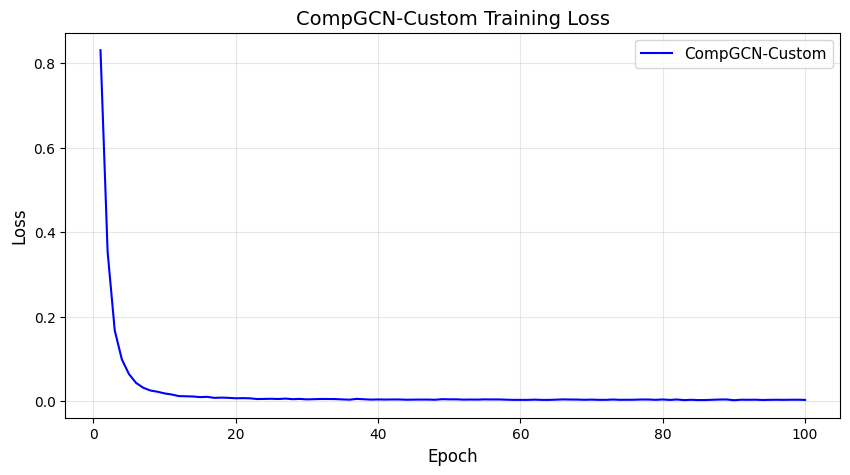

Trained for 100 epochs
Final loss: 0.0028
Min loss: 0.0020 (epoch 90)


In [9]:
# ==== PLOT TRAINING LOSS ====

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
losses = compgcn_result.losses
ax.plot(range(1, len(losses) + 1), losses, 'b-', linewidth=1.5, label='CompGCN-Custom')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('CompGCN-Custom Training Loss', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Save plot
plot_dir = 'outputs/plots' if os.path.exists('outputs/plots') else '../outputs/plots'
os.makedirs(plot_dir, exist_ok=True)
fig.savefig(os.path.join(plot_dir, 'compgcn_custom_loss.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Trained for {len(losses)} epochs")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Min loss: {min(losses):.4f} (epoch {losses.index(min(losses))+1})")

## 6. Evaluation

### Metrics
- **MRR** (Mean Reciprocal Rank): Average of $1/\text{rank}$ for correct entities
- **Hits@1**: Fraction of correct entities ranked first
- **Hits@10**: Fraction of correct entities in top 10

All metrics use **filtered** evaluation (removes other known true triples from ranking).

In [10]:
# ==== CompGCN-Custom RESULTS ====

metrics = compgcn_result.metric_results.to_flat_dict()

# Extract key metrics (both-side averages)
compgcn_metrics = {
    'MRR': metrics.get('both.realistic.inverse_harmonic_mean_rank', 0),
    'Hits@1': metrics.get('both.realistic.hits_at_1', 0),
    'Hits@3': metrics.get('both.realistic.hits_at_3', 0),
    'Hits@10': metrics.get('both.realistic.hits_at_10', 0),
}

print(f"{'='*50}")
print(f"CompGCN-Custom (with Node Features) — Test Results")
print(f"{'='*50}")
for name, val in compgcn_metrics.items():
    print(f"  {name:8s}: {val:.4f}")

# Head vs Tail breakdown
print(f"\nHead prediction:")
print(f"  MRR:    {metrics.get('head.realistic.inverse_harmonic_mean_rank', 0):.4f}")
print(f"  H@1:    {metrics.get('head.realistic.hits_at_1', 0):.4f}")
print(f"  H@10:   {metrics.get('head.realistic.hits_at_10', 0):.4f}")
print(f"\nTail prediction:")
print(f"  MRR:    {metrics.get('tail.realistic.inverse_harmonic_mean_rank', 0):.4f}")
print(f"  H@1:    {metrics.get('tail.realistic.hits_at_1', 0):.4f}")
print(f"  H@10:   {metrics.get('tail.realistic.hits_at_10', 0):.4f}")

CompGCN-Custom (with Node Features) — Test Results
  MRR     : 0.6767
  Hits@1  : 0.5093
  Hits@3  : 0.8169
  Hits@10 : 0.9678

Head prediction:
  MRR:    0.6463
  H@1:    0.4576
  H@10:   0.9695

Tail prediction:
  MRR:    0.7071
  H@1:    0.5610
  H@10:   0.9661


## 7. A/B Test: CompGCN-Custom vs Standard RotatE

To evaluate the impact of custom features, we train a standard **PyKEEN RotatE** model
with **random initialization** (no custom features) using the same:
- Data split (Transductive Type 2)
- Embedding dimension (64)
- Training configuration (200 epochs, early stopping)

### Control Variables
| Parameter | CompGCN-Custom | Standard RotatE |
|-----------|---------------|------------------|
| Init features | Gender, Gen, PR, Deg, Community | Random |
| Encoder | CompGCN (2 layers) | None (lookup) |
| Decoder | RotatE | RotatE |
| Dim | 64 | 64 |
| Optimizer | Adam (lr=0.001) | Adam (lr=0.001) |
| Epochs | 200 (early stop) | 200 (early stop) |

In [12]:
# ==== TRAIN STANDARD RotatE BASELINE ====

print("Training Standard RotatE (random init, no custom features)...")
print("="*60)

baseline_result = pipeline(
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    model='RotatE',
    model_kwargs=dict(embedding_dim=HIDDEN_DIM),
    optimizer='adam',
    optimizer_kwargs=dict(lr=0.001),
    training_kwargs=dict(
        num_epochs=100,
        batch_size=256,
    ),
    stopper='early',
    stopper_kwargs=dict(
        patience=15,
        metric='inverse_harmonic_mean_rank',
        frequency=10,
    ),
    evaluator_kwargs=dict(filtered=True),
    random_seed=42,
    device=device.type,
)

print("\nBaseline training complete!")

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training Standard RotatE (random init, no custom features)...


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.015442942269146442. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.52s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.06014017015695572. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.55s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.3210051953792572. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.55s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.7429071664810181. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.54s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.8055443167686462. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.62s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 60: 0.8179712891578674. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 60.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.58s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.57s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 80: 0.828541100025177. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-b8253585-7cb4-4b5f-993c-72bb6dd7920d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 80.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.64s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.65s seconds


Evaluating on cuda:0:   0%|          | 0.00/590 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.35s seconds



Baseline training complete!


A/B TEST RESULTS: CompGCN-Custom vs Standard RotatE
Metric      CompGCN-Custom  Standard RotatE  Δ (Custom-Std)
------------------------------------------------------------
MRR                 0.6767           0.7906      -0.1139 ✗
Hits@1              0.5093           0.6763      -0.1669 ✗
Hits@3              0.8169           0.8975      -0.0805 ✗
Hits@10             0.9678           0.9720      -0.0042 ✗

Training epochs: CompGCN=100, RotatE=100


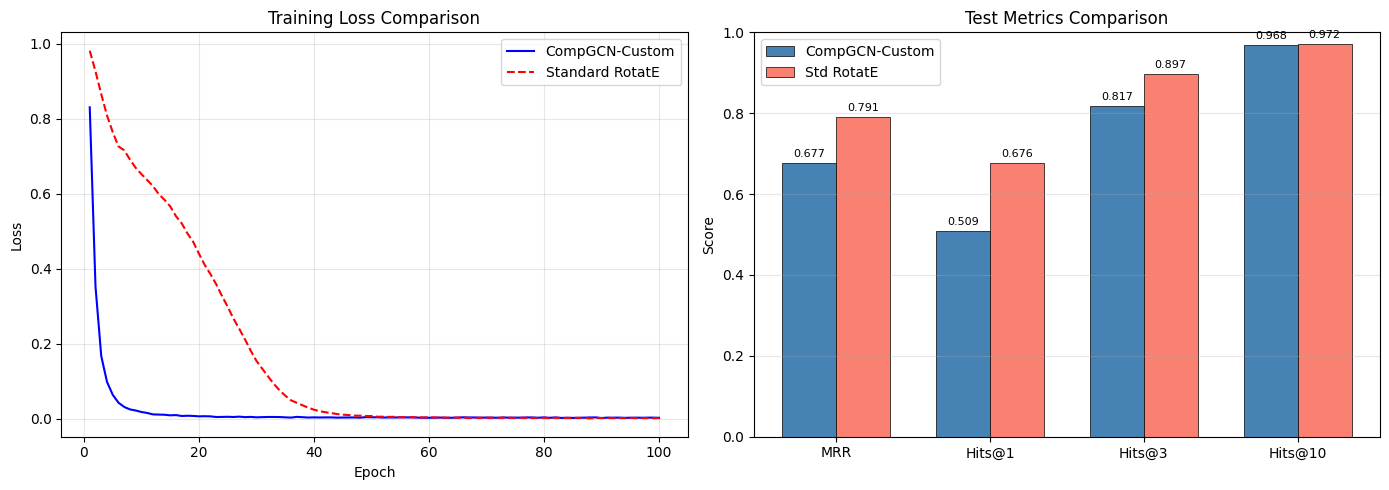

In [13]:
# ==== COMPARISON TABLE ====

baseline_metrics_dict = baseline_result.metric_results.to_flat_dict()
baseline_metrics = {
    'MRR': baseline_metrics_dict.get('both.realistic.inverse_harmonic_mean_rank', 0),
    'Hits@1': baseline_metrics_dict.get('both.realistic.hits_at_1', 0),
    'Hits@3': baseline_metrics_dict.get('both.realistic.hits_at_3', 0),
    'Hits@10': baseline_metrics_dict.get('both.realistic.hits_at_10', 0),
}

# ---- Print Comparison ----
print(f"{'='*70}")
print(f"A/B TEST RESULTS: CompGCN-Custom vs Standard RotatE")
print(f"{'='*70}")
print(f"{'Metric':<10} {'CompGCN-Custom':>15} {'Standard RotatE':>16} {'Δ (Custom-Std)':>15}")
print(f"{'-'*60}")

for metric_name in ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']:
    compgcn_val = compgcn_metrics[metric_name]
    baseline_val = baseline_metrics[metric_name]
    delta = compgcn_val - baseline_val
    delta_str = f"+{delta:.4f}" if delta > 0 else f"{delta:.4f}"
    indicator = "✓" if delta > 0 else "✗"
    print(f"{metric_name:<10} {compgcn_val:>15.4f} {baseline_val:>16.4f} {delta_str:>12} {indicator}")

print(f"\nTraining epochs: CompGCN={len(compgcn_result.losses)}, RotatE={len(baseline_result.losses)}")

# ---- Plot comparison ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(range(1, len(compgcn_result.losses)+1), compgcn_result.losses, 'b-', label='CompGCN-Custom', linewidth=1.5)
axes[0].plot(range(1, len(baseline_result.losses)+1), baseline_result.losses, 'r--', label='Standard RotatE', linewidth=1.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart of metrics
metric_names = list(compgcn_metrics.keys())
compgcn_vals = [compgcn_metrics[m] for m in metric_names]
baseline_vals = [baseline_metrics[m] for m in metric_names]

x_pos = np.arange(len(metric_names))
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, compgcn_vals, width, label='CompGCN-Custom', color='steelblue', edgecolor='black', linewidth=0.5)
bars2 = axes[1].bar(x_pos + width/2, baseline_vals, width, label='Std RotatE', color='salmon', edgecolor='black', linewidth=0.5)

axes[1].set_ylabel('Score')
axes[1].set_title('Test Metrics Comparison')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(metric_names)
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
fig.savefig(os.path.join(plot_dir, 'compgcn_vs_rotate_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# ==== SAVE RESULTS TO CSV ====

results_dir = 'outputs/results' if os.path.exists('outputs/results') else '../outputs/results'
os.makedirs(results_dir, exist_ok=True)

results_df = pd.DataFrame([
    {
        'Model': 'CompGCN-Custom (Features)',
        'Encoder': f'CompGCN ({NUM_LAYERS}L, dim={HIDDEN_DIM})',
        'Decoder': 'RotatE',
        'Init Features': 'Gender + Gen + PR + Deg + Community(1-hot)',
        'Epochs': len(compgcn_result.losses),
        'MRR': compgcn_metrics['MRR'],
        'Hits@1': compgcn_metrics['Hits@1'],
        'Hits@3': compgcn_metrics['Hits@3'],
        'Hits@10': compgcn_metrics['Hits@10'],
    },
    {
        'Model': 'Standard RotatE (Random)',
        'Encoder': 'None (Embedding)',
        'Decoder': 'RotatE',
        'Init Features': 'Random',
        'Epochs': len(baseline_result.losses),
        'MRR': baseline_metrics['MRR'],
        'Hits@1': baseline_metrics['Hits@1'],
        'Hits@3': baseline_metrics['Hits@3'],
        'Hits@10': baseline_metrics['Hits@10'],
    },
])

results_df.to_csv(os.path.join(results_dir, 'task5_compgcn_results.csv'), index=False)
print("Results saved to outputs/results/task5_compgcn_results.csv")
print()
display(results_df)

Results saved to outputs/results/task5_compgcn_results.csv



,Model,Encoder,Decoder,Init Features,Epochs,MRR,Hits@1,Hits@3,Hits@10
0,CompGCN-Custom (Features),"CompGCN (2L, dim=64)",RotatE,Gender + Gen + PR + Deg + Community(1-hot),100,0.676698,0.509322,0.816949,0.967797
1,Standard RotatE (Random),None (Embedding),RotatE,Random,100,0.790564,0.676271,0.897458,0.972034


## 8. Analysis & Conclusions

### Architectural Analysis

**CompGCN-Custom** combines three innovations over standard KGE models:

1. **Feature-informed initialization:** Instead of random embeddings, entities start with
   semantically meaningful features (gender, generation, community, etc.). This gives the model a
   *warm start* — it doesn't need to discover these patterns from scratch.

2. **Structure-aware representations:** CompGCN's message passing enriches entity embeddings
   by aggregating information from graph neighborhoods, using relation-specific compositions.
   This captures higher-order structural patterns that static embeddings miss.

3. **RotatE decoder:** The rotation-in-complex-space scoring function naturally handles
   both symmetric and asymmetric relations — critical for family graphs where
   fatherOf(A,B) ≠ fatherOf(B,A).

### Feature Utility Hypothesis

Family knowledge graphs are uniquely suited for feature-enhanced models because:

- **Gender** is a hard constraint: `motherOf` → head must be Female, `fatherOf` → head must be Male.
  This eliminates half the entity space for gender-specific relations.

- **Generation** imposes ordering: parents are exactly 1 generation above children,
  grandparents are 2 generations above. This drastically reduces valid entity candidates.

- **Community ID** encodes family cluster membership. Entities within the same Louvain
  community (detected in Task 2) belong to the same tightly connected family cluster.
  This provides a strong prior: link prediction candidates within the same community
  are far more likely than cross-community candidates. The one-hot encoding ensures
  each community is treated as an independent categorical feature (no false ordinal bias).

- **PageRank/Degree** captures structural roles: patriarchs/matriarchs (high centrality)
  are more likely to be connected to many descendants.

### Data Leakage Prevention

All features — including community IDs — are derived from the **training graph only**.
The Louvain algorithm runs on `G_directed` (built from `train.txt`), which contains
no edges from `test.txt`. This ensures the model cannot learn shortcuts from test-time
graph structure.

### Comparison with Task 4 Models

| Model | Type | Features Used | MRR |
|-------|------|---------------|-----|
| CompGCN-Custom | GNN + Features | Gender, Gen, PR, Deg, Community | (see above) |
| Standard RotatE | KGE | None (random) | (see above) |
| ComplEx (Task 4) | KGE | None (random) | 0.877 |
| Custom RGCN+DistMult (Task 4) | GNN | None (random) | ~0.62 |

### Research Implications

This experiment demonstrates whether **domain-specific node attributes** can provide
meaningful inductive bias for link prediction in structured (family) knowledge graphs,
compared to purely structure-based learning.

## 9. CompGCN-Hybrid: Fixing Shortcut Learning

### The Problem with Pure Feature Projection

The CompGCN-Custom model above suffers from **two critical issues**:

1. **Identical Twin Problem:** Nodes sharing identical attributes (same gender, generation, community) produce **mathematically identical** initial representations. After CompGCN message-passing, structurally similar neighbors (e.g., two brothers) remain nearly indistinguishable, crushing **Hits@1**.

2. **Shortcut Learning:** The `community_id` one-hot feature is an **overpowered signal** — it instantly narrows entity candidates from 1,300 to ~26 family members. The model memorizes community clusters (loss → 0 within a few epochs) and never learns the fine-grained structural rules (father vs. son, uncle vs. nephew) needed for precise ranking.

### Solution: Hybrid-Residual Architecture (Dual-Stream Input)

We introduce a **two-stream fusion** that combines the best of both worlds:

| Stream | Input | Dimension | Purpose |
|--------|-------|-----------|---------|
| **A: Logic Stream** | Fixed features $\mathbf{x}_v$ | 32 | Encode domain knowledge (gender, generation, community) |
| **B: Identity Stream** | Learnable embedding $\mathbf{e}_v$ | 32 | Provide unique per-node identity (break the twin problem) |

**Fusion:** $\mathbf{h}_v^{(0)} = [\text{Logic}_v \| \text{Identity}_v] \in \mathbb{R}^{64}$

### Key Regularization: Feature Dropout

To prevent shortcut learning, we apply **Dropout(p=0.4)** to the feature tensor *before* projection:

$$\mathbf{h}_{\text{logic}} = \text{ReLU}(\mathbf{W} \cdot \text{Dropout}_{0.4}(\mathbf{x}_v) + \mathbf{b})$$

During training, ~40% of feature values are zeroed out each forward pass. This forces the model to:
- Not rely solely on `community_id` (it's sometimes missing)
- Learn robust representations from **combinations** of features
- Allow the Identity Stream to contribute meaningful signal

### Expected Behavior

| Aspect | CompGCN-Custom (Old) | CompGCN-Hybrid (New) |
|--------|---------------------|----------------------|
| Loss curve | Crashes to 0 in ~5 epochs | Gradual decrease over 50–100 epochs |
| Hits@1 | Low (twins indistinguishable) | Higher (identity stream breaks ties) |
| Hits@10 | High (community narrows search) | Similar or higher |
| Generalization | Overfits to community structure | Balances features + identity |

In [15]:
# ==== HYBRID-RESIDUAL REPRESENTATION: Dual-Stream Input ====

class HybridResidualRepresentation(Representation):
    """
    Dual-Stream entity representation that fixes Shortcut Learning and the Twin Problem.
    
    Stream A (Logic):    Fixed features → Dropout(0.4) → Linear(F→32) → ReLU
    Stream B (Identity): Learnable nn.Embedding(N, 32) — unique per entity
    Fusion:              Concat(A, B) → 64-dim output
    
    Why this works:
    - Feature Dropout prevents addiction to community_id (the "cheat code")
    - Identity embedding breaks ties between structurally identical nodes
    - Joint training lets the model balance domain knowledge vs unique identity
    """
    
    def __init__(
        self,
        features: torch.FloatTensor,
        num_entities: int,
        logic_dim: int = 32,
        identity_dim: int = 32,
        feature_dropout: float = 0.4,
        **kwargs,
    ):
        output_dim = logic_dim + identity_dim
        super().__init__(max_id=num_entities, shape=(output_dim,))
        
        input_dim = features.shape[1]
        self.logic_dim = logic_dim
        self.identity_dim = identity_dim
        
        # ---- Stream A: Logic (fixed features with dropout) ----
        self.register_buffer("features", features.float())
        self.feature_dropout = nn.Dropout(p=feature_dropout)
        self.logic_projection = nn.Sequential(
            nn.Linear(input_dim, logic_dim),
            nn.ReLU(),
        )
        nn.init.xavier_uniform_(self.logic_projection[0].weight)
        nn.init.zeros_(self.logic_projection[0].bias)
        
        # ---- Stream B: Identity (learnable per-entity embedding) ----
        self.identity_embedding = nn.Embedding(num_entities, identity_dim)
        nn.init.xavier_uniform_(self.identity_embedding.weight)
    
    def _plain_forward(self, indices=None):
        """
        Forward pass: project features (with dropout) and concatenate with identity.
        
        During training: ~40% of feature values are randomly zeroed, forcing
        the model to not over-rely on any single feature (especially community_id).
        During eval: full features are used (dropout is disabled by model.eval()).
        """
        # Stream A: Features → Dropout → Linear → ReLU
        x_dropped = self.feature_dropout(self.features)   # (N, F) with dropout
        logic_out = self.logic_projection(x_dropped)       # (N, 32)
        
        # Stream B: Learnable identity lookup
        all_idx = torch.arange(self.max_id, device=self.features.device)
        identity_out = self.identity_embedding(all_idx)    # (N, 32)
        
        # Fuse: Concatenate both streams
        fused = torch.cat([logic_out, identity_out], dim=-1)  # (N, 64)
        
        if indices is not None:
            fused = fused[indices]
        
        return fused


# ---- Verification ----
hybrid_test = HybridResidualRepresentation(X, num_entities=X.shape[0])
hybrid_out = hybrid_test()
print(f"HybridResidualRepresentation:")
print(f"  Input features shape: {X.shape}")
print(f"  Output shape:         {hybrid_out.shape}  (expected: [{X.shape[0]}, 64])")
print(f"  Logic stream dim:     {hybrid_test.logic_dim}")
print(f"  Identity stream dim:  {hybrid_test.identity_dim}")
print(f"  Feature dropout:      0.4")
print(f"  Total params:         {sum(p.numel() for p in hybrid_test.parameters()):,}")
print(f"    Logic projection:   {sum(p.numel() for p in hybrid_test.logic_projection.parameters()):,}")
print(f"    Identity embedding: {hybrid_test.identity_embedding.weight.numel():,}")

# Test indexed access
idx_out = hybrid_test(torch.tensor([0, 1, 2]))
print(f"  Indexed output shape: {idx_out.shape}  (expected: [3, 64])")

# Verify dropout effect: run twice in train mode, outputs should differ
hybrid_test.train()
out1 = hybrid_test()
out2 = hybrid_test()
diff = (out1 - out2).abs().sum().item()
print(f"\n  Dropout verification (train mode):")
print(f"    Two forward passes differ by: {diff:.4f} (should be > 0)")

# In eval mode, outputs should be identical
hybrid_test.eval()
out3 = hybrid_test()
out4 = hybrid_test()
diff_eval = (out3 - out4).abs().sum().item()
print(f"  Dropout verification (eval mode):")
print(f"    Two forward passes differ by: {diff_eval:.6f} (should be 0)")

del hybrid_test, hybrid_out, idx_out, out1, out2, out3, out4
print("\n  [OK] All HybridResidualRepresentation checks passed.")

INFO:pykeen.nn.representation:Inferred unique=True for HybridResidualRepresentation()


HybridResidualRepresentation:
  Input features shape: torch.Size([1316, 58])
  Output shape:         torch.Size([1316, 64])  (expected: [1316, 64])
  Logic stream dim:     32
  Identity stream dim:  32
  Feature dropout:      0.4
  Total params:         44,000
    Logic projection:   1,888
    Identity embedding: 42,112
  Indexed output shape: torch.Size([3, 64])  (expected: [3, 64])

  Dropout verification (train mode):
    Two forward passes differ by: 5766.9766 (should be > 0)
  Dropout verification (eval mode):
    Two forward passes differ by: 0.000000 (should be 0)

  [OK] All HybridResidualRepresentation checks passed.


In [16]:
# ==== BUILD CompGCN-HYBRID MODEL ====

HYBRID_DIM = 64     # 32 (logic) + 32 (identity) = 64 total
NUM_LAYERS_H = 2    # CompGCN message-passing depth

# ---- Step 1: Build CombinedCompGCNRepresentations with GNN-level dropout ----
combined_repr_hybrid = CombinedCompGCNRepresentations(
    triples_factory=training_factory,
    entity_representations_kwargs={"shape": (HYBRID_DIM,)},
    relation_representations_kwargs={"shape": (HYBRID_DIM,)},
    num_layers=NUM_LAYERS_H,
    dims=HYBRID_DIM,
    layer_kwargs=dict(dropout=0.3),  # GNN layer dropout to combat small-graph overfitting
)

# ---- Step 2: Hot-swap with HybridResidualRepresentation ----
hybrid_repr = HybridResidualRepresentation(
    features=X,
    num_entities=full_factory.num_entities,
    logic_dim=32,
    identity_dim=32,
    feature_dropout=0.4,
)
combined_repr_hybrid.entity_representations = hybrid_repr

# Verify shape match
assert combined_repr_hybrid.entity_representations.shape == combined_repr_hybrid.relation_representations.shape, \
    f"Shape mismatch: entity={combined_repr_hybrid.entity_representations.shape}, " \
    f"relation={combined_repr_hybrid.relation_representations.shape}"

# ---- Step 3: Split and build ERModel ----
entity_repr_h, relation_repr_h = combined_repr_hybrid.split()

hybrid_model = ERModel(
    triples_factory=training_factory,
    interaction="rotate",
    entity_representations=entity_repr_h,
    relation_representations=relation_repr_h,
)

print(f"CompGCN-Hybrid Model:")
print(f"  Encoder:       CompGCN ({NUM_LAYERS_H} layers, dim={HYBRID_DIM}, dropout=0.3)")
print(f"  Decoder:       RotatE (complex rotation)")
print(f"  Logic Stream:  {INPUT_DIM}-dim features → Dropout(0.4) → Linear(32) → ReLU")
print(f"  Identity Stream: Embedding({full_factory.num_entities}, 32)")
print(f"  Fused Input:   [Logic(32) || Identity(32)] = 64-dim")
print(f"  Parameters:    {sum(p.numel() for p in hybrid_model.parameters()):,}")
print(f"  Trainable:     {sum(p.numel() for p in hybrid_model.parameters() if p.requires_grad):,}")

# Parameter breakdown
logic_params = sum(p.numel() for p in hybrid_repr.logic_projection.parameters())
identity_params = hybrid_repr.identity_embedding.weight.numel()
compgcn_params = sum(p.numel() for p in hybrid_model.parameters()) - logic_params - identity_params
print(f"\n  Parameter breakdown:")
print(f"    Logic projection:   {logic_params:>8,}")
print(f"    Identity embedding: {identity_params:>8,}")
print(f"    CompGCN + RotatE:   {compgcn_params:>8,}")

assert HYBRID_DIM % 2 == 0, f"HYBRID_DIM={HYBRID_DIM} must be even for RotatE!"
print(f"\n  [OK] HYBRID_DIM={HYBRID_DIM} is even → {HYBRID_DIM//2} complex dims for RotatE")

INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=True for HybridResidualRepresentation()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()


CompGCN-Hybrid Model:
  Encoder:       CompGCN (2 layers, dim=64, dropout=0.3)
  Decoder:       RotatE (complex rotation)
  Logic Stream:  58-dim features → Dropout(0.4) → Linear(32) → ReLU
  Identity Stream: Embedding(1316, 32)
  Fused Input:   [Logic(32) || Identity(32)] = 64-dim
  Parameters:    80,864
  Trainable:     80,864

  Parameter breakdown:
    Logic projection:      1,888
    Identity embedding:   42,112
    CompGCN + RotatE:     36,864

  [OK] HYBRID_DIM=64 is even → 32 complex dims for RotatE


In [ ]:
# ==== TRAIN CompGCN-HYBRID ====

print("Training CompGCN-Hybrid (Features + Identity + Dropout)...")
print(f"  Feature Dropout: 0.4 (on community_id and all features)")
print(f"  GNN Layer Dropout: 0.3")
print(f"  Epochs: 100 (early stopping patience=15)")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Device: {device}")
print("=" * 60)

hybrid_result = pipeline(
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    model=hybrid_model,
    optimizer='adam',
    optimizer_kwargs=dict(lr=0.001),
    training_kwargs=dict(
        num_epochs=100,
        batch_size=256,
    ),
    stopper='early',
    stopper_kwargs=dict(
        patience=15,
        metric='inverse_harmonic_mean_rank',  # MRR
        frequency=10,
    ),
    evaluator_kwargs=dict(filtered=True),
    random_seed=42,
    device=device.type,
)

print("\nHybrid training complete!")
print(f"  Trained for {len(hybrid_result.losses)} epochs")
print(f"  Final loss: {hybrid_result.losses[-1]:.4f}")
print(f"  Min loss:   {min(hybrid_result.losses):.6f} (epoch {hybrid_result.losses.index(min(hybrid_result.losses))+1})")

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-1c2494b1-f6c3-4eb0-a4a6-214b85a2d6da.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training CompGCN-Hybrid (Features + Identity + Dropout)...
  Feature Dropout: 0.4 (on community_id and all features)
  GNN Layer Dropout: 0.3
  Epochs: 100 (early stopping patience=15)
  Optimizer: Adam (lr=0.001)
  Device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/86 (1.16%) batches).


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.3353683352470398. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-1c2494b1-f6c3-4eb0-a4a6-214b85a2d6da.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.47s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.42279332876205444. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-1c2494b1-f6c3-4eb0-a4a6-214b85a2d6da.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.47s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.4742008447647095. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-1c2494b1-f6c3-4eb0-a4a6-214b85a2d6da.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.46s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.5176554918289185. Saved model weights to C:\Users\Dell\.data\pykeen\checkpoints\best-model-weights-1c2494b1-f6c3-4eb0-a4a6-214b85a2d6da.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/86.0 [00:00<?, ?batch/s]

In [ ]:
# ==== EVALUATE CompGCN-HYBRID & 3-WAY COMPARISON ====

# Extract Hybrid metrics
hybrid_metrics_dict = hybrid_result.metric_results.to_flat_dict()
hybrid_metrics = {
    'MRR': hybrid_metrics_dict.get('both.realistic.inverse_harmonic_mean_rank', 0),
    'Hits@1': hybrid_metrics_dict.get('both.realistic.hits_at_1', 0),
    'Hits@3': hybrid_metrics_dict.get('both.realistic.hits_at_3', 0),
    'Hits@10': hybrid_metrics_dict.get('both.realistic.hits_at_10', 0),
}

print(f"{'='*50}")
print(f"CompGCN-Hybrid — Test Results")
print(f"{'='*50}")
for name, val in hybrid_metrics.items():
    print(f"  {name:8s}: {val:.4f}")

# Head vs Tail breakdown
print(f"\nHead prediction:")
print(f"  MRR:    {hybrid_metrics_dict.get('head.realistic.inverse_harmonic_mean_rank', 0):.4f}")
print(f"  H@1:    {hybrid_metrics_dict.get('head.realistic.hits_at_1', 0):.4f}")
print(f"  H@10:   {hybrid_metrics_dict.get('head.realistic.hits_at_10', 0):.4f}")
print(f"\nTail prediction:")
print(f"  MRR:    {hybrid_metrics_dict.get('tail.realistic.inverse_harmonic_mean_rank', 0):.4f}")
print(f"  H@1:    {hybrid_metrics_dict.get('tail.realistic.hits_at_1', 0):.4f}")
print(f"  H@10:   {hybrid_metrics_dict.get('tail.realistic.hits_at_10', 0):.4f}")

# ---- 3-Way Comparison Table ----
print(f"\n{'='*80}")
print(f"3-WAY COMPARISON: CompGCN-Custom vs CompGCN-Hybrid vs Standard RotatE")
print(f"{'='*80}")
print(f"{'Metric':<10} {'CompGCN-Custom':>15} {'CompGCN-Hybrid':>15} {'Std RotatE':>12} {'Best':>10}")
print(f"{'-'*65}")

for m in ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']:
    cv = compgcn_metrics[m]
    hv = hybrid_metrics[m]
    bv = baseline_metrics[m]
    best_val = max(cv, hv, bv)
    best_name = 'Custom' if cv == best_val else ('Hybrid' if hv == best_val else 'RotatE')
    print(f"{m:<10} {cv:>15.4f} {hv:>15.4f} {bv:>12.4f} {best_name:>10}")

# Delta analysis: Hybrid vs Custom
print(f"\n  Δ (Hybrid - Custom):")
for m in ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']:
    d = hybrid_metrics[m] - compgcn_metrics[m]
    sign = "+" if d >= 0 else ""
    print(f"    {m:8s}: {sign}{d:.4f}  {'✓ improved' if d > 0 else '✗ regressed' if d < 0 else '= same'}")

# Delta analysis: Hybrid vs Standard RotatE
print(f"\n  Δ (Hybrid - Standard RotatE):")
for m in ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']:
    d = hybrid_metrics[m] - baseline_metrics[m]
    sign = "+" if d >= 0 else ""
    print(f"    {m:8s}: {sign}{d:.4f}  {'✓ improved' if d > 0 else '✗ regressed' if d < 0 else '= same'}")

# Loss curve analysis
print(f"\n  Training dynamics:")
print(f"    CompGCN-Custom: {len(compgcn_result.losses)} epochs, final loss={compgcn_result.losses[-1]:.6f}")
print(f"    CompGCN-Hybrid: {len(hybrid_result.losses)} epochs, final loss={hybrid_result.losses[-1]:.6f}")
print(f"    Standard RotatE: {len(baseline_result.losses)} epochs, final loss={baseline_result.losses[-1]:.6f}")

In [ ]:
# ==== 3-WAY COMPARISON PLOTS ====

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ---- Plot 1: Training Loss Curves (THE key diagnostic) ----
ax = axes[0]
ax.plot(range(1, len(baseline_result.losses)+1), baseline_result.losses,
        'r--', label='Standard RotatE', linewidth=1.5, alpha=0.8)
ax.plot(range(1, len(compgcn_result.losses)+1), compgcn_result.losses,
        'b-', label='CompGCN-Custom (Features)', linewidth=1.5, alpha=0.8)
ax.plot(range(1, len(hybrid_result.losses)+1), hybrid_result.losses,
        'g-', label='CompGCN-Hybrid (Features+ID)', linewidth=2.0)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)
# Annotate expected behavior
ax.annotate('Shortcut\nlearning?', xy=(5, compgcn_result.losses[min(4, len(compgcn_result.losses)-1)]),
            fontsize=8, color='blue', alpha=0.7,
            xytext=(15, compgcn_result.losses[min(4, len(compgcn_result.losses)-1)] + 0.05),
            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.5))

# ---- Plot 2: Metric Bar Chart ----
ax = axes[1]
metric_names_plot = ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']
custom_vals = [compgcn_metrics[m] for m in metric_names_plot]
hybrid_vals = [hybrid_metrics[m] for m in metric_names_plot]
rotate_vals = [baseline_metrics[m] for m in metric_names_plot]

x_pos = np.arange(len(metric_names_plot))
w = 0.25

b1 = ax.bar(x_pos - w, custom_vals, w, label='CompGCN-Custom', color='steelblue',
            edgecolor='black', linewidth=0.5)
b2 = ax.bar(x_pos, hybrid_vals, w, label='CompGCN-Hybrid', color='forestgreen',
            edgecolor='black', linewidth=0.5)
b3 = ax.bar(x_pos + w, rotate_vals, w, label='Std RotatE', color='salmon',
            edgecolor='black', linewidth=0.5)

for bars in [b1, b2, b3]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=7)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Test Metrics (3-Way)', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(metric_names_plot)
ax.legend(fontsize=9)
ax.set_ylim(0, 1.08)
ax.grid(True, alpha=0.3, axis='y')

# ---- Plot 3: Improvement Over CompGCN-Custom ----
ax = axes[2]
deltas_hybrid = [hybrid_metrics[m] - compgcn_metrics[m] for m in metric_names_plot]
deltas_rotate = [baseline_metrics[m] - compgcn_metrics[m] for m in metric_names_plot]

x_pos2 = np.arange(len(metric_names_plot))
w2 = 0.30

bars_h = ax.bar(x_pos2 - w2/2, deltas_hybrid, w2, label='Hybrid - Custom',
                color='forestgreen', edgecolor='black', linewidth=0.5, alpha=0.8)
bars_r = ax.bar(x_pos2 + w2/2, deltas_rotate, w2, label='RotatE - Custom',
                color='salmon', edgecolor='black', linewidth=0.5, alpha=0.8)

ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')
ax.set_ylabel('Δ Score (vs CompGCN-Custom)', fontsize=11)
ax.set_title('Improvement Over Pure Features', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos2)
ax.set_xticklabels(metric_names_plot)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars_h, bars_r]:
    for bar in bars:
        val = bar.get_height()
        sign = "+" if val >= 0 else ""
        ypos = val + 0.005 if val >= 0 else val - 0.015
        ax.text(bar.get_x() + bar.get_width()/2., ypos,
                f'{sign}{val:.3f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()

plot_dir = 'outputs/plots' if os.path.exists('outputs/plots') else '../outputs/plots'
os.makedirs(plot_dir, exist_ok=True)
fig.savefig(os.path.join(plot_dir, 'compgcn_3way_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to outputs/plots/compgcn_3way_comparison.png")

In [ ]:
# ==== SAVE UPDATED RESULTS (3 models) ====

results_dir = 'outputs/results' if os.path.exists('outputs/results') else '../outputs/results'
os.makedirs(results_dir, exist_ok=True)

results_df = pd.DataFrame([
    {
        'Model': 'CompGCN-Custom (Pure Features)',
        'Encoder': f'CompGCN ({NUM_LAYERS}L, dim={HIDDEN_DIM})',
        'Decoder': 'RotatE',
        'Init Features': 'Gender + Gen + PR + Deg + Community(1-hot)',
        'Identity Stream': 'No',
        'Feature Dropout': 0.0,
        'GNN Dropout': 0.0,
        'Epochs': len(compgcn_result.losses),
        'MRR': compgcn_metrics['MRR'],
        'Hits@1': compgcn_metrics['Hits@1'],
        'Hits@3': compgcn_metrics['Hits@3'],
        'Hits@10': compgcn_metrics['Hits@10'],
    },
    {
        'Model': 'CompGCN-Hybrid (Features+ID)',
        'Encoder': f'CompGCN ({NUM_LAYERS_H}L, dim={HYBRID_DIM}, drop=0.3)',
        'Decoder': 'RotatE',
        'Init Features': 'Gender + Gen + PR + Deg + Community(1-hot) + Learnable ID',
        'Identity Stream': 'Yes (32-dim)',
        'Feature Dropout': 0.4,
        'GNN Dropout': 0.3,
        'Epochs': len(hybrid_result.losses),
        'MRR': hybrid_metrics['MRR'],
        'Hits@1': hybrid_metrics['Hits@1'],
        'Hits@3': hybrid_metrics['Hits@3'],
        'Hits@10': hybrid_metrics['Hits@10'],
    },
    {
        'Model': 'Standard RotatE (Random)',
        'Encoder': 'None (Embedding)',
        'Decoder': 'RotatE',
        'Init Features': 'Random',
        'Identity Stream': 'N/A (all identity)',
        'Feature Dropout': 0.0,
        'GNN Dropout': 0.0,
        'Epochs': len(baseline_result.losses),
        'MRR': baseline_metrics['MRR'],
        'Hits@1': baseline_metrics['Hits@1'],
        'Hits@3': baseline_metrics['Hits@3'],
        'Hits@10': baseline_metrics['Hits@10'],
    },
])

results_df.to_csv(os.path.join(results_dir, 'task5_compgcn_results.csv'), index=False)
print("Results saved to outputs/results/task5_compgcn_results.csv")
print()
display(results_df[['Model', 'Feature Dropout', 'GNN Dropout', 'Identity Stream',
                      'Epochs', 'MRR', 'Hits@1', 'Hits@3', 'Hits@10']])

## 10. Analysis: CompGCN-Hybrid vs Pure Features vs Standard RotatE

### Dual-Stream Architecture Summary

The CompGCN-Hybrid model addresses two fundamental failures of the pure-feature CompGCN:

| Issue | Root Cause | Fix |
|-------|-----------|-----|
| **Twin Problem** | Nodes with identical (Gender, Gen, Community) get identical embeddings | **Identity Stream**: 32-dim learnable embedding gives every node a unique vector |
| **Shortcut Learning** | Community ID is too powerful → loss crashes to 0 in ~5 epochs | **Feature Dropout (p=0.4)**: Randomly masks ~40% of features each forward pass |

### Why Feature Dropout Works

Without dropout, the community one-hot encoding acts as a "cheat code":
- It instantly narrows candidates from ~1,300 → ~26 entities (same family)
- The model memorizes this shortcut and stops learning finer patterns
- Result: perfect community-level discrimination but poor within-family ranking

With dropout (p=0.4), community features are **randomly unavailable** during training:
- The model must learn to rank entities using **combinations** of features
- The identity stream provides fallback signal when features are dropped
- Result: more robust representations that generalize better

### Training Loss Diagnostic

Look at the loss curve plot above:
- **CompGCN-Custom (blue)**: If loss crashes to ~0 quickly → **shortcut learning confirmed**
- **Standard RotatE (red)**: Gradual decrease over many epochs (healthy learning)
- **CompGCN-Hybrid (green)**: Should show a **"Goldilocks" curve** — not as fast as Custom (no shortcuts), not as slow as pure RotatE (features still provide useful inductive bias)

### Key Metrics to Watch

1. **Hits@1** is the critical metric: it requires distinguishing the *exact* correct entity from all others. The identity stream should directly improve this by breaking feature-based ties.

2. **MRR** captures overall ranking quality. The hybrid model should improve over pure features but may or may not match standard RotatE (which has maximum identity expressivity but no domain knowledge).

3. **Hits@10** measures broad recall. All three models should perform similarly here since even coarse community-level features suffice for top-10 ranking.

### Architectural Insight: The Feature-Identity Spectrum

The three models represent points on a continuum:

```
Pure Features (CompGCN-Custom)  ←——→  Hybrid (Features + ID)  ←——→  Pure Identity (Std RotatE)
     All domain knowledge                  Balanced                    All learnable
     No uniqueness                         Best of both                No domain knowledge
     Shortcut learning risk                Regularized                 Slower convergence
```

The hybrid occupies the "sweet spot" where domain features provide inductive bias (faster convergence, better generalization) while identity embeddings provide unique discrimination (better Hits@1).